**MLP PROJECT**

Train Data Shape: (100000, 77)
Test Data Shape: (10000, 76)

Missing Values in Train Data:
RealTimeProtectionState                66
AntivirusConfigID                      76
NumAntivirusProductsInstalled          76
NumAntivirusProductsEnabled            76
CityID                                623
IsSystemProtected                      76
SMode                                 981
IEVersionID                           107
FirewallEnabled                       166
EnableLUA                              19
OEMNameID                             212
OEMModelID                            228
ProcessorCoreCount                     85
ProcessorManufacturerID                85
ProcessorModelID                       85
PrimaryDiskCapacityMB                 110
PrimaryDiskType                        23
SystemVolumeCapacityMB                110
TotalPhysicalRAMMB                    151
ChassisType                             2
PrimaryDisplayDiagonalInches           72
PrimaryDisplayResolutionHor

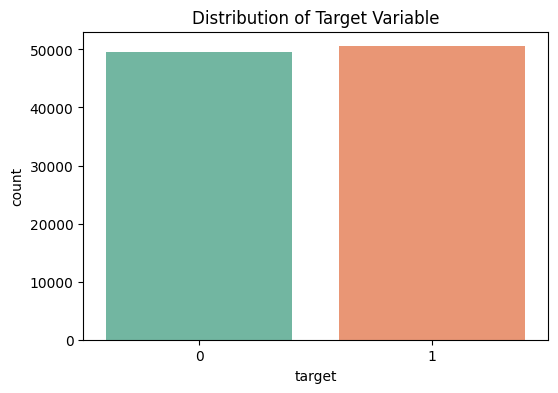

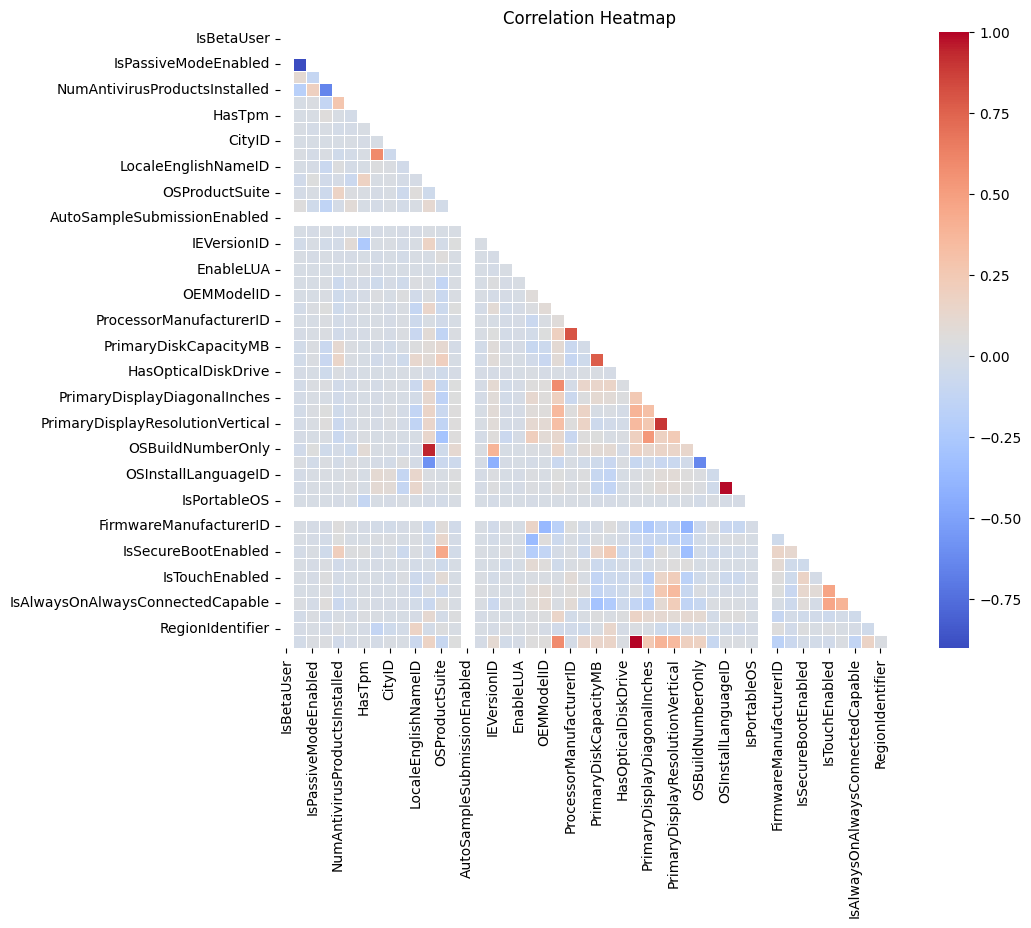

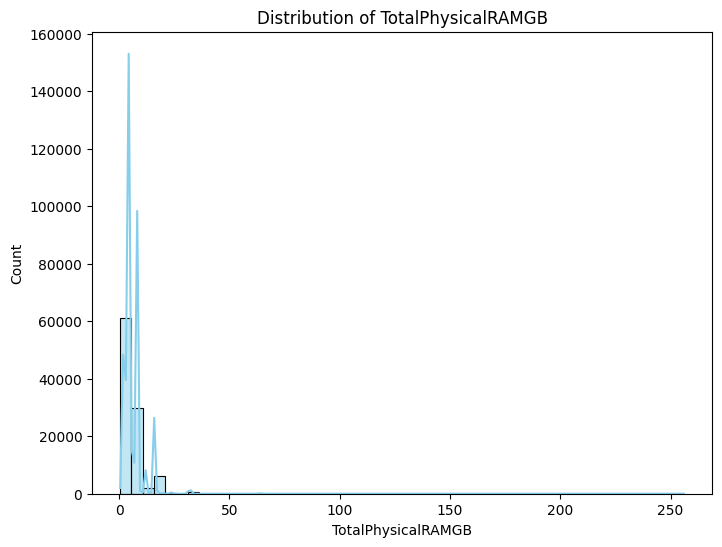

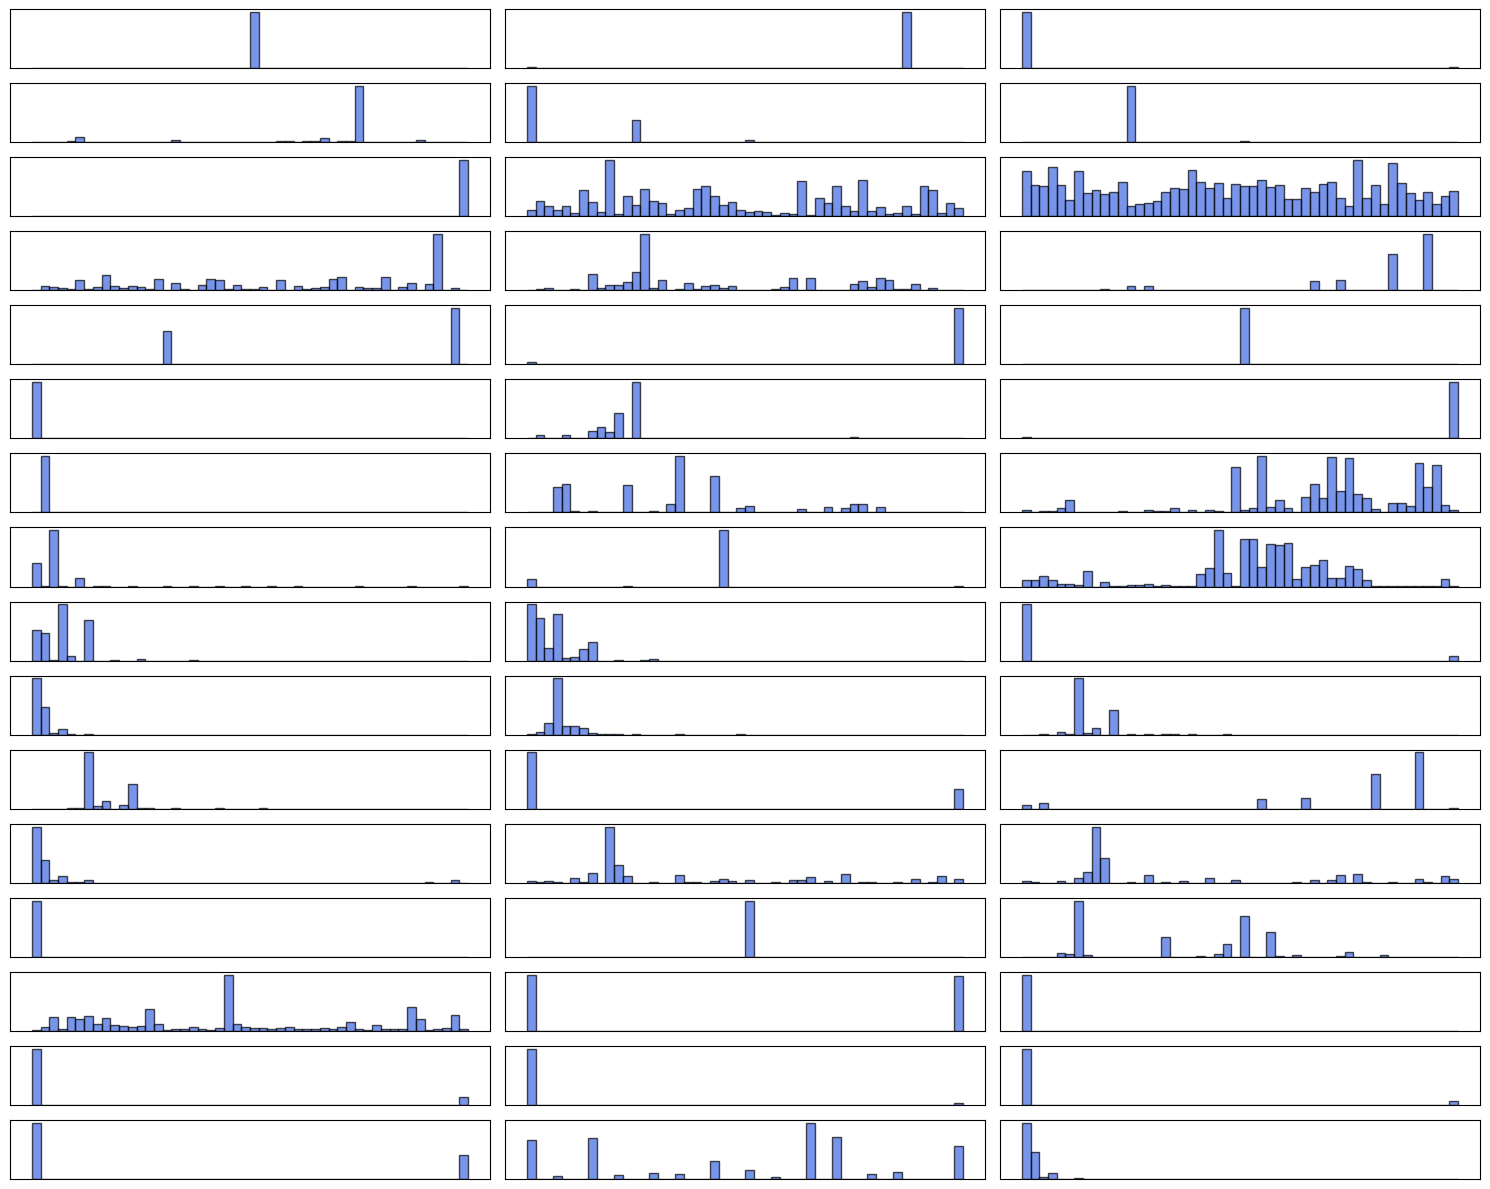

In [ ]:
# Import Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import GaussianNB
from sklearn.compose import ColumnTransformer
import warnings

warnings.filterwarnings("ignore")

# Load Data
train_df = pd.read_csv("/kaggle/input/System-Threat-Forecaster/train.csv")
test_df = pd.read_csv("/kaggle/input/System-Threat-Forecaster/test.csv")

# Feature Engineering
train_df['TotalPhysicalRAMGB'] = train_df['TotalPhysicalRAMMB'] / 1024
test_df['TotalPhysicalRAMGB'] = test_df['TotalPhysicalRAMMB'] / 1024

print(f"Train Data Shape: {train_df.shape}")
print(f"Test Data Shape: {test_df.shape}")

# EDA: Check Missing Values
print("\nMissing Values in Train Data:")
print(train_df.isnull().sum()[train_df.isnull().sum() > 0])

print("\nMissing Values in Test Data:")
print(test_df.isnull().sum()[test_df.isnull().sum() > 0])

# EDA: Distribution of Target Variable
plt.figure(figsize=(6, 4))
sns.countplot(x='target', data=train_df, palette='Set2')
plt.title("Distribution of Target Variable")
plt.show()

#Identify Categorical and Numerical Columns
num_cols = train_df.select_dtypes(include=[np.number]).columns.tolist()
if "target" in num_cols:
    num_cols.remove("target")
cat_cols = train_df.select_dtypes(exclude=[np.number]).columns.tolist()

# EDA: Correlation Heatmap
plt.figure(figsize=(10, 8))
corr = train_df[num_cols].corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(corr, mask=mask,  cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Correlation Heatmap")
plt.show()

# EDA: Distribution of One Numerical Feature (e.g., TotalPhysicalRAMGB)
plt.figure(figsize=(8, 6))
sns.histplot(train_df['TotalPhysicalRAMGB'], kde=True, bins=50, color='skyblue')
plt.title("Distribution of TotalPhysicalRAMGB")
plt.show()

# EDA: Skewness
n_cols = 3
n_rows = (len(num_cols) + n_cols - 1) // n_cols
fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(15, 12))
axes = axes.flatten() 
for i, col in enumerate(num_cols):
    train_df[col].hist(ax=axes[i], bins=50, edgecolor='black', alpha=0.7, color='royalblue')
    axes[i].grid(False)
    axes[i].set_xlabel("")
    axes[i].set_ylabel("")
    axes[i].tick_params(axis='both', which='both', bottom=False, left=False)
    axes[i].set_xticklabels([])
    axes[i].set_yticklabels([])
    for spine in axes[i].spines.values():
        spine.set_edgecolor('black') 
        spine.set_linewidth(0.8) 
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])
plt.tight_layout()
plt.show()

# Handle Missing Values
#1. Numerical Columns: Impute with Median
imputer = SimpleImputer(strategy='median')
train_df[num_cols] = imputer.fit_transform(train_df[num_cols])
test_df[num_cols] = imputer.transform(test_df[num_cols])

#2. Categorical Columns: Label Encoding
label_encoders = {}
for col in cat_cols:
    le = LabelEncoder()
    train_df[col] = le.fit_transform(train_df[col].astype(str))
    test_df[col] = test_df[col].astype(str).map(lambda x: le.transform([x])[0] if x in le.classes_ else -1)
    label_encoders[col] = le

# Feature Scaling
scaler = StandardScaler()
train_df[num_cols] = scaler.fit_transform(train_df[num_cols])
test_df[num_cols] = scaler.transform(test_df[num_cols])

# Train-Validation Split
X = train_df.drop(columns=['target'])
y = train_df['target']
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

Random Forest

Random Forest Validation Accuracy: 0.5857

Classification Report:
              precision    recall  f1-score   support

           0       0.62      0.41      0.49      9895
           1       0.57      0.76      0.65     10105

    accuracy                           0.59     20000
   macro avg       0.60      0.58      0.57     20000
weighted avg       0.60      0.59      0.57     20000



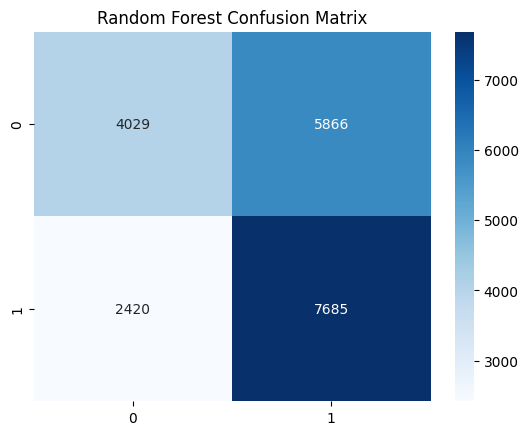

In [3]:
num_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')), 
    ('scaler', StandardScaler())  
])

cat_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),  
    ('onehot', OneHotEncoder(handle_unknown='ignore')) 
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_transformer, num_cols),
        ('cat', cat_transformer, cat_cols)
    ])

# Train (Pipeline)
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', RandomForestClassifier(n_estimators=200, random_state=42, max_depth=10, min_samples_split=5))
])

# Fit the pipeline
model.fit(X_train, y_train)

# Evaluate
y_pred_rf = model.predict(X_val)
rf_accuracy = accuracy_score(y_val, y_pred_rf)
print(f"Random Forest Validation Accuracy: {rf_accuracy:.4f}")
print("\nClassification Report:")
print(classification_report(y_val, y_pred_rf))
sns.heatmap(confusion_matrix(y_val, y_pred_rf), annot=True, fmt='d', cmap="Blues")
plt.title("Random Forest Confusion Matrix")
plt.show()

Decision Tree

Decision Tree Validation Accuracy: 0.6060

Classification Report:
              precision    recall  f1-score   support

           0       0.63      0.50      0.56      9895
           1       0.59      0.71      0.64     10105

    accuracy                           0.61     20000
   macro avg       0.61      0.60      0.60     20000
weighted avg       0.61      0.61      0.60     20000



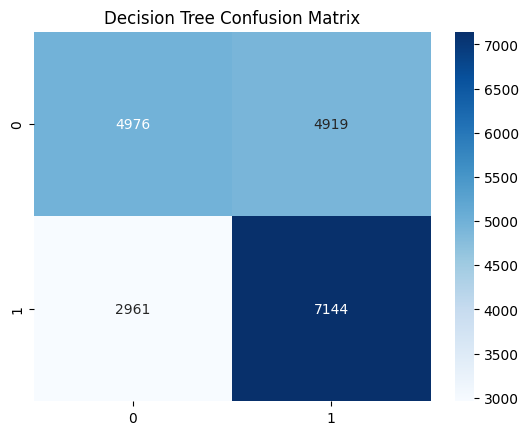

In [4]:
# Train
dt_param_grid = {
    'max_depth': [3, 5, 10, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}
model_rough = GridSearchCV(DecisionTreeClassifier(random_state=42), dt_param_grid, cv=5, scoring='accuracy')
model_rough.fit(X_train, y_train)
model = model_rough.best_estimator_

# Evaluate
y_pred_dt = model.predict(X_val)
dt_accuracy = accuracy_score(y_val, y_pred_dt)
print(f"Decision Tree Validation Accuracy: {dt_accuracy:.4f}")
print("\nClassification Report:")
print(classification_report(y_val, y_pred_dt))
sns.heatmap(confusion_matrix(y_val, y_pred_dt), annot=True, fmt='d', cmap="Blues")
plt.title("Decision Tree Confusion Matrix")
plt.show()

XGBoost

XGBoost Validation Accuracy: 0.6297

Classification Report:
              precision    recall  f1-score   support

           0       0.63      0.60      0.61      9895
           1       0.63      0.66      0.64     10105

    accuracy                           0.63     20000
   macro avg       0.63      0.63      0.63     20000
weighted avg       0.63      0.63      0.63     20000



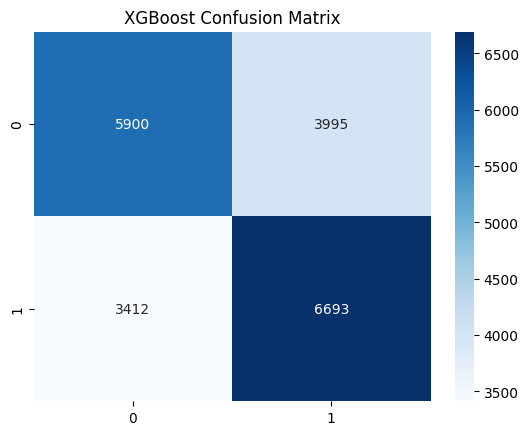

In [5]:
# Train
model = XGBClassifier(
    n_estimators=500, 
    learning_rate=0.03, 
    max_depth=9, 
    subsample=0.9, 
    colsample_bytree=0.9, 
    gamma=0.1,  
    reg_lambda=1,  
    random_state=42
)

model.fit(X_train, y_train)

# Evaluate
y_pred_xgb = model.predict(X_val)
xgb_accuracy = accuracy_score(y_val, y_pred_xgb)
print(f"XGBoost Validation Accuracy: {xgb_accuracy:.4f}")
print("\nClassification Report:")
print(classification_report(y_val, y_pred_xgb))
sns.heatmap(confusion_matrix(y_val, y_pred_xgb), annot=True, fmt='d', cmap="Blues")
plt.title("XGBoost Confusion Matrix")
plt.show()

In [6]:
print(f"Random Forest Accuracy {rf_accuracy}")
print(f"Decision Tree Accuracy {dt_accuracy}")
print(f"XGBOOST Accuracy {xgb_accuracy}")
print("Thus XGBOOST is our best model")

Random Forest Accuracy 0.5857
Decision Tree Accuracy 0.606
XGBOOST Accuracy 0.62965
Thus XGBOOST is our best model


In [8]:
test_predictions = model.predict(test_df[X_train.columns])
submission = pd.DataFrame({'id': range(len(test_predictions)), 'target': test_predictions})
submission.to_csv('submission.csv', index=False)
print("Submitted")

Submitted
